# Quantum Error Correction with the Surface-17 Code

Quantum computers promise exponential speedups for problems in chemistry, cryptography, optimization, and more. But quantum information is **notoriously fragile**—qubits are susceptible to decoherence, gate errors, measurement noise, and crosstalk. Without protection, even the simplest quantum programs can become unreliable.

To build scalable quantum hardware, we *need* **quantum error correction (QEC)**. It’s not a luxury—it’s a necessity.

And yet, while tutorials abound for Shor’s algorithm, Grover’s search, and other foundational quantum algorithms, **practical, accessible walkthroughs of QEC—especially surface codes—are still hard to find**.

Having recently studied surface codes myself, I wanted to deepen my understanding the way Richard Feynman recommended: **by teaching it**. This notebook is my attempt to break down surface-code QEC from the ground up—for you, and for me.

---

### What this notebook covers

This is a hands-on, end-to-end guide to implementing a surface-code QEC cycle using the **Surface-17** layout—a resource-optimized, experimentally realistic variant of the distance-3 surface code.

You'll learn how to:
- Start from classical repetition codes and transition to quantum codes
- Understand stabilizers and how they detect quantum errors
- Construct stabilizer measurement circuits using Qiskit 2.0+
- Decode syndromes using a simple lookup decoder
- Run a simple 2-qubit stabilizer code on real IBM Quantum hardware

And if you’re not sure what a surface code or code distance even is—don’t worry. We’ll build everything from first principles. Whether you’re a student, researcher, or quantum engineer, by the end of this notebook you’ll understand how QEC works **not just in theory—but in circuits, code, and real devices**.

---

### What this notebook assumes you know
- Basics of quantum computing

**Let's dive right in!**

## Section 1 - From Classical Repetition to Quantum Bit-Flip Code
### 1.1 Classical Repetition Code
Let's begin by demonstrating a simple classical repetition code; we encode a logical bit 0 $\to$ `000`. 

> **Exercise:** Complete the repetition code by including a "correction" function to correct the flipped bit. 

In [1]:
# Classical repetition
def classical_majority_vote(bits):
    """
    Performs a majority vote on an n-bit string.
    """
    return int(bits.count('1') > 1)

def correct_bit(bits):
    # YOUR CODE HERE
    return bits

print("Classical Repetition Example:")
print("Input: 010 -> Decoded:", classical_majority_vote("010"))
print("Input: 100 -> Decoded:", classical_majority_vote("100"))

# What if two bits are flipped?
print("Input: 110 -> Decoded:", classical_majority_vote("110"))

Classical Repetition Example:
Input: 010 -> Decoded: 0
Input: 100 -> Decoded: 0
Input: 110 -> Decoded: 1


Let’s take a second look at the final example in our code above: `110`. If our initial state was `000` and the system underwent 2 bit-flip errors, our `classical_majority_vote` function would only be able to **detect** the error, not **correct** it. In fact, with a distance-3 code, we can detect up to 2 errors but can **only correct** 1.

Formally, the number of errors a code can correct is given by
$t = \left\lfloor \frac{d - 1}{2} \right\rfloor,$
where $d$ is the distance of the code. In our case, since $d = 3$, we have $t = 1$.

Now, let's move to the quantum world.

### 1.2 Primer on Quantum Errors

Before we can correct quantum errors, we need to understand what kinds of errors quantum systems are susceptible to—and how they differ from classical noise.

---

#### Coherent vs. Incoherent Errors

Quantum errors fall into two broad categories:

- **Incoherent errors** arise from unwanted interactions between a qubit and its surrounding environment. These are *stochastic* in nature—examples include spontaneous decay (amplitude damping), thermal noise, and dephasing.

- **Coherent errors** are systematic and unitary. Think of them as unintended over- or under-rotations—like a slightly miscalibrated gate. While coherent errors may seem less threatening, they can build up in a correlated and dangerous way over time.

---

#### Why Quantum Error Correction Is Harder Than Classical

Quantum systems come with several unique challenges that classical bits do not:

1. **No cloning**: We can’t simply copy qubits and compare them.
2. **Dual error types**: Both bit flips and phase flips can occur—and independently.
3. **No direct measurement**: Measuring a qubit generally collapses its state, destroying the quantum information we’re trying to protect.

So how do we correct errors without collapsing the state?

---

#### We Can’t Copy Qubits!

In classical computing, error correction is straightforward: copy the data and use majority voting. That’s what the classical repetition code does.

But quantum information **cannot be copied** due to the **no-cloning theorem**:

> There is no unitary operator $U$ such that for all quantum states $|\psi\rangle$,  
> $U |\psi\rangle|0\rangle = |\psi\rangle|\psi\rangle$

In fact, this restriction is *fundamental* to quantum mechanics—it arises from the linearity of quantum evolution.

> **Exercise:** Prove the no-cloning theorem. Suppose two arbitrary states $|\psi\rangle$ and $|\phi\rangle$ can both be cloned by some unitary $U$. Show that this leads to a contradiction unless $|\psi\rangle = |\phi\rangle$ or they are orthogonal.

---

#### The Digitization of Quantum Noise

Here’s the remarkable insight that makes quantum error correction possible:

> **Any arbitrary error process on a qubit can be decomposed into a linear combination of Pauli operators.**

This is known as the **digitization of quantum errors**. The set $\{I, X, Y, Z\}$ forms a basis for single-qubit errors. That means any quantum noise process—no matter how complicated—can be expressed as a weighted sum of these Pauli terms acting on a qubit.

So how does this help us correct errors?

Quantum error correction protocols work by **measuring a carefully chosen set of observables called stabilizers**. These stabilizers are Pauli operators (or products of Pauli operators) that are designed to commute with the encoded logical state. They don't reveal the actual encoded data—instead, they detect whether an error has moved the system out of the valid codespace.

The **outcomes** of these stabilizer measurements—either $+1$ or $-1$—form what's called a **syndrome**: a binary pattern that helps us infer what kind of error occurred and where. Most importantly, these measurements are performed **using ancilla qubits**: auxiliary qubits that interact with the data qubits in such a way that we can extract the syndrome *without collapsing the logical qubit itself*.

In effect, stabilizers let us turn a continuous quantum error into a discrete classical message—the syndrome—that tells us what recovery operation to apply.

Thus, it suffices to correct:
- **Bit-flip errors**: $X$
- **Phase-flip errors**: $Z$
- **Combined bit+phase errors**: $Y = iXZ$

Correcting these three Pauli errors is enough to correct *any* single-qubit error.

---

#### So what can we do?

Instead of copying, we **encode** quantum information into **entangled states** of multiple physical qubits.

To detect errors, we use special observables called **stabilizers**. These are multi-qubit measurements that reveal whether and where an error has occurred, without disturbing the encoded quantum state. The outcome of such a measurement is called a **syndrome**—a classical bit string indicating the likely error pattern.  We don’t measure the logical qubit directly. Instead, stabilizers give us indirect access to errors via their syndromes—without collapsing the encoded quantum information. It’s how we detect and correct errors **without destroying the quantum information**.

In the next section, we’ll see how this principle works in the simplest setting: the 2-qubit toy quantum bit-flip code that can detect but not correct bit-flip errors.


### 1.3 2-Qubit Toy Quantum Bit-Flip Detection Code

Here, we do the following:

- Encode \$|\psi\rangle \rightarrow \alpha|00\rangle + \beta|11\rangle\$
- Introduce \$Z\_1Z\_2\$ stabilizer
- Inject \$X\_1\$ or \$X\_2\$ errors
- Measure syndrome with ancilla

In [10]:
# Begin by importing the necessary libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

%matplotlib inline

-----------------------
Measurement Results
-----------------------
1 -> 1024 shots (100.00%)


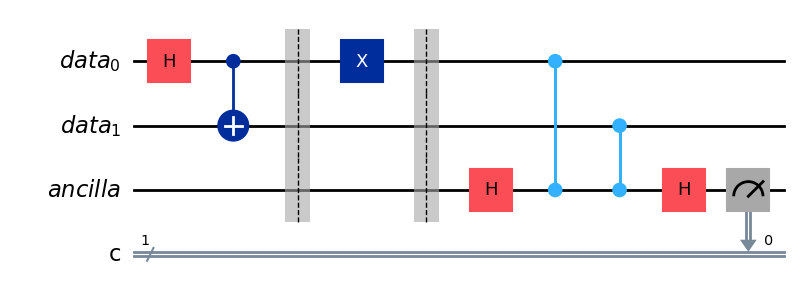

In [22]:
# Define the registers
data = QuantumRegister(2, 'data') # data qubits
anc = QuantumRegister(1, 'ancilla') # ancilla for our stabilizers
c = ClassicalRegister(1, 'c') # Classical bit for our syndrome

# create the circuit
qc = QuantumCircuit(data, anc, c)

# --- Step 1: Encode logical |psi> = (|00> + |11>)/sqrt(2) ---
qc.h(data[0]) # |0> -> (|0> + |1>)/sqrt(2)
qc.cx(data[0], data[1]) # (|0> + |1>)/sqrt(2) -> (|00> + |11>)/sqrt(2)

qc.barrier()

# --- Step X: ERROR! Inject a bit-flip error ---
qc.x(data[0]) # now our state is: (|10> + |01>)/sqrt(2)

qc.barrier()

# --- Step 2: Measure stabilizer Z1 Z2 using ancilla ---
qc.h(anc[0]) # to put our ancilla in X-basis: |+>
qc.cz(data[0], anc[0]) # Apply stabilizer Z0 -> if this qubit has flipped, our state will change to |->
qc.cz(data[1], anc[0]) # Apply stabilizer Z1 -> if this qubit has flipped, our state will change to |->
qc.h(anc[0]) # back to Z basis
qc.measure(anc[0], c[0])

# ---- Step 3: Simulate and display ----
qc.draw("mpl")
backend = AerSimulator()
transpiled = transpile(qc, backend) # Transpile our circuit down to basis gates
job = backend.run(transpiled, shots=1024)
result = job.result()
counts = result.get_counts()

print("-----------------------")
print("Measurement Results")
print("-----------------------")
for outcome, freq in sorted(counts.items()):
    percent = 100 * freq / 1024
    print(f"{outcome} -> {freq} shots ({percent:.2f}%)")

#### Let's Reflect: What Just Happened?

We just implemented a basic quantum error **detection** code. Here's what we did, step by step:

1. **Encoding**:  
   We encoded our logical qubit  
   $|\psi\rangle \rightarrow \alpha|00\rangle + \beta|11\rangle$  
   by first placing `data[0]` in a superposition and then entangling it with `data[1]` using a CNOT. This forms a simple repetition code in the quantum domain.

2. **Error Injection**:  
   We deliberately applied a bit-flip error to the first qubit using a Pauli $X$ gate, simulating the effect of a physical noise process.

3. **Syndrome Measurement**:  
   To detect this error, we prepared the ancilla in the $X$-basis, applied `CZ` gates from each data qubit to the ancilla, then returned it to the $Z$-basis via a Hadamard. This measures the stabilizer $Z_1Z_2$ without collapsing the logical state.

4. **Detection**:  
   Finally, we measured the ancilla. A measurement result of `'1'` indicates that a bit-flip error occurred; `'0'` means no detectable error.

---

> **Exercise:** Step through the circuit manually and compute the statevector after each step. Show explicitly how the ancilla measurement reflects whether the input state was in the $+1$ or $-1$ eigenspace of $Z_1Z_2$.

---

#### Key Limitations

- This code can **detect** a single bit-flip, but it **cannot localize** it. There's no way to tell if it was `data[0]` or `data[1]` that flipped.
- If both qubits are flipped (a correlated error), the final state is still a valid codeword—**but logically flipped**. The syndrome measurement reports no error, even though a logical error occurred.

---

This brings us to a more rigorous and general way to describe such behavior: the **stabilizer formalism**. Before we build the surface code, we’ll first explore the mathematical foundation that powers these quantum error-correcting codes.

## Section 2 - The Stabilizer Formalism

So far, we’ve learned how to encode a logical qubit into multiple physical qubits and detect errors using carefully designed measurements. But how do we scale this into a general framework for quantum codes, especially for complex systems like surface codes?

The answer lies in **stabilizer formalism**.

---

#### What is a Stabilizer?

In quantum error correction, a **stabilizer** is a Pauli operator (or product of Pauli operators) that:

- Leaves the encoded logical state unchanged:
  $S |\psi_L\rangle = +1 \cdot |\psi_L\rangle$
- But flips sign if an error has occurred:
  $S E |\psi_L\rangle = -1 \cdot E |\psi_L\rangle$

That sign flip tells us something went wrong—without collapsing the quantum state. Stabilizers **detect** errors while preserving logical information.

---

#### Codespace, Stabilizer Group, and Syndromes

Define the **codespace** $\mathcal{C}$ as the set of states stabilized by a group $\mathcal{S}$ of commuting Pauli operators:

$$
\mathcal{C} = \{ |\psi\rangle \in \mathcal{H}^{\otimes n} \;|\; S_i |\psi\rangle = +|\psi\rangle \quad \forall S_i \in \mathcal{S} \}
$$

- $\mathcal{S}$: Stabilizer group (set of Pauli checks)
- $n$: Number of physical qubits
- $r = \text{rank}(\mathcal{S})$: Number of independent stabilizer generators
- $k = n - r$: Number of logical qubits
- $\mathcal{C}$: The space of valid code states (all pass stabilizer checks)

---

When an error $E$ occurs, it might **anticommute** with some stabilizers. Measuring those stabilizers then returns $-1$ instead of $+1$. The resulting pattern of measurement outcomes is called the **syndrome**.

- Each stabilizer gives **one bit** of information
- The syndrome reveals *where* and *what kind* of error likely occurred
- A decoder uses this information to choose a correction that returns the system to the codespace

---

#### Example: The 3-Qubit Bit-Flip Code

Suppose the 3-Qubit Bit-Flip Code has the following stabilizer group:

$\mathcal{S} = \langle Z_0 Z_1,\; Z_1 Z_2 \rangle$

- Logical states:
  $|0_L\rangle = |000\rangle,\quad |1_L\rangle = |111\rangle$

Each possible bit-flip error yields a unique syndrome:
- $X_0 \Rightarrow [-1, +1]$
- $X_1 \Rightarrow [-1, -1]$
- $X_2 \Rightarrow [+1, -1]$

This lets us both **detect and locate** the error.

---

#### Stabilizer Measurement with Ancillas

To measure a stabilizer like $Z_i Z_j$ without disturbing the data qubits:

1. Prepare an ancilla qubit in $|0\rangle$
2. Apply `CX` gates: data $\rightarrow$ ancilla
3. Measure the ancilla

The outcome reveals whether the parity of the data qubits is flipped—i.e., whether the stabilizer returned $+1$ or $-1$.

---

#### Understanding Why This Works

Errors like $X$, $Z$, or $Y$ disturb the stabilizers they anticommute with. By measuring the full set of stabilizers:

- We get a **syndrome vector** indicating which checks failed
- We can locate and correct errors without learning the encoded logical state
- This enables **fault-tolerant** recovery from noise in quantum computation

Stabilizer formalism scales naturally to larger codes (like the surface code) where many stabilizers are measured in parallel, and decoders reconstruct error chains from syndrome data.


## Section 3 - What is a Surface Code?

The **surface code** is one of the most powerful and experimentally viable quantum error-correcting codes to date. It belongs to the family of **topological stabilizer codes**, meaning that it encodes quantum information in the geometry of a 2D lattice. Fault-tolerance and error detection emerge not from redundancy alone, but from the structure of the lattice itself.

---

### Key Features of Surface Codes

- **Local Interactions**  
  All stabilizers are composed of **nearest-neighbor** qubits—perfect for architectures like IBM's superconducting qubits, which support only local two-qubit gates.

- **Two Types of Stabilizers**  
  Each face of the code corresponds to one of two stabilizer types:
  - **X-type (star)** stabilizers detect **bit-flip** errors.
  - **Z-type (plaquette)** stabilizers detect **phase-flip** errors.

- **Topological Encoding**  
  Logical operators are long strings of Pauli operators (like XXXX... or ZZZZ...) stretching across the lattice. Errors must form a *connected chain* across the code to cause a logical failure.

- **Code Distance $d$**  
  Determines how many errors the code can tolerate. A distance-$d$ surface code can correct up to $\left\lfloor \frac{d - 1}{2} \right\rfloor$ arbitrary single-qubit errors.

---

> **Exercise**  
> Examine the figure below. White circles are **data qubits** and black circles are **ancilla (syndrome) qubits**.  
> - Light-colored patches represent **Z-type stabilizers**  
> - Dark-colored (square/triangular) patches represent **X-type stabilizers**  
> Write down the stabilizers explicitly from the diagram.

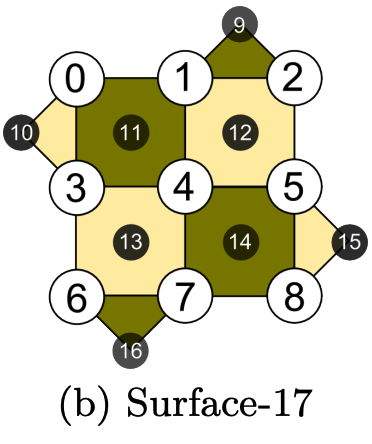

*Source: "Low Distance Surface Codes Under Realistic Quantum Noise" ([arXiv:1404.3747](https://arxiv.org/pdf/1404.3747))*

---

### The Lattice Structure

In a surface code of distance $d$, we arrange:

- $n$ **data qubits** that store the encoded quantum state.
- $n - k$ **ancilla qubits** (syndrome qubits) used to measure stabilizers without collapsing logical information.

Each stabilizer typically acts on 4 adjacent data qubits (a square “plaquette” or “star”), enabling the code to detect localized errors and infer their positions using classical decoding.

---

### Why Surface Codes?

- **High Fault Tolerance**  
  Surface codes tolerate physical error rates up to ~1%—a regime within reach of today’s hardware.

- **Modularity & Scalability**  
  Logical qubits can be scaled up using techniques like patching, braiding, and lattice surgery.

- **Hardware Compatibility**  
  Their 2D structure and local gates make surface codes an ideal match for current quantum processors.

---

We now turn to a specific layout: the **distance-3 surface-17 code**. It uses 17 physical qubits—9 data and 8 ancilla—to encode a single logical qubit.


### 3.1 The Surface-17 Code

Each stabilizer acts on a local patch of 2–4 data qubits. From the diagram below, let's extract the stabilizers.

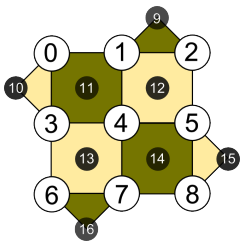

*Here's the diagram again. White circles = data qubits. Black circles = ancilla (syndrome) qubits. Light patches = Z-stabilizers. Dark patches = X-stabilizers. Adapted from [arXiv:1404.3747](https://arxiv.org/pdf/1404.3747).*

**Z-type stabilizers:**
- $Z_0 Z_3$
- $Z_1 Z_2 Z_4 Z_5$
- $Z_3 Z_4 Z_6 Z_7$
- $Z_5 Z_8$

**X-type stabilizers:**
- $X_0 X_1 X_3 X_4$
- $X_1 X_2$
- $X_4 X_5 X_7 X_8$
- $X_6 X_7$

These operators are chosen to mutually commute and preserve the codespace. Their eigenvalues (±1) reveal error syndromes that we’ll use for decoding.

---

We can now implement these stabilizers in Qiskit, simulate their measurement, and examine how they respond to injected errors. To implement the stabilizers, let's refer to another helpful diagram in the paper:

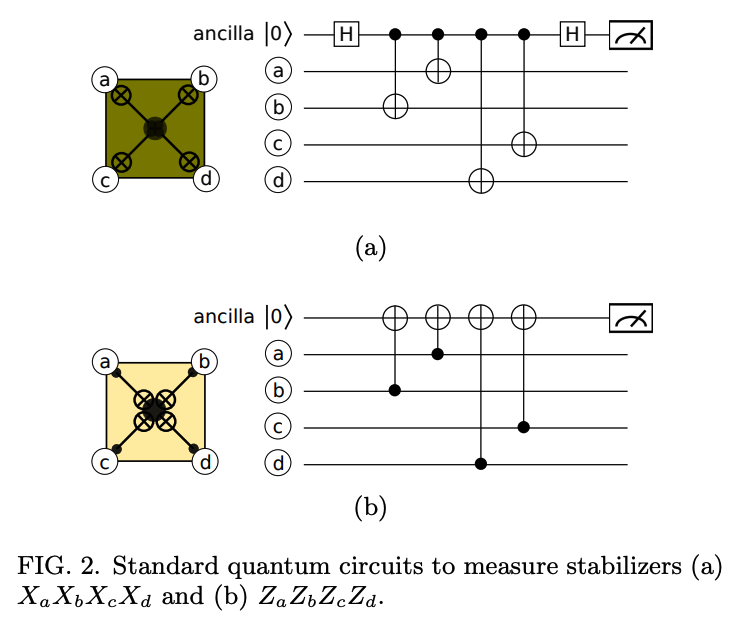


In [11]:
# Define the stabilizer patterns for Surface-17
z_stabs = [[0, 3], [1, 2, 4, 5], [3, 4, 6, 7], [5, 8]]
x_stabs = [[0, 1, 3, 4], [1, 2], [4, 5, 7, 8], [6, 7]]

def measure_z_stabilizer(qc, anc_idx, data_indices, cbit_idx, data, anc, cr):
    """
    Measures a Z-type stabilizer using an ancilla qubit.

    Parameters:
    - qc (QuantumCircuit): the quantum circuit being built
    - anc_idx (int): index of the ancilla qubit in the `anc` register
    - data_indices (List[int]): indices of data qubits (in `data` register) involved in the stabilizer
    - cbit_idx (int): index of classical bit in `cr` to store the measurement result
    - data (QuantumRegister): register of data qubits
    - anc (QuantumRegister): register of ancilla (syndrome) qubits
    - cr (ClassicalRegister): classical register for storing measurement outcomes
    """
    # Reset ancilla to |0⟩ state
    qc.reset(anc[anc_idx])
    
    # For Z-stabilizer, we use CNOT gates with data qubits as control
    for d in data_indices:
        qc.cx(data[d], anc[anc_idx])

    qc.measure(anc[anc_idx], cr[cbit_idx])

def measure_x_stabilizer(qc, anc_idx, data_indices, cbit_idx, data, anc, cr):
    """
    Measures an X-type stabilizer using an ancilla qubit.

    Parameters:
    - qc (QuantumCircuit): the quantum circuit being built
    - anc_idx (int): index of the ancilla qubit in the `anc` register
    - data_indices (List[int]): indices of data qubits (in `data` register) involved in the stabilizer
    - cbit_idx (int): index of classical bit in `cr` to store the measurement result
    - data (QuantumRegister): register of data qubits
    - anc (QuantumRegister): register of ancilla (syndrome) qubits
    - cr (ClassicalRegister): classical register for storing measurement outcomes
    """
    # Reset ancilla to |0⟩ state
    qc.reset(anc[anc_idx])
    
    # Prepare ancilla in |+⟩ state
    qc.h(anc[anc_idx])
    
    # For X-stabilizer, we use CNOT gates with ancilla as control
    for d in data_indices:
        qc.cx(anc[anc_idx], data[d])
        
    # Measure in X basis
    qc.h(anc[anc_idx])
    qc.measure(anc[anc_idx], cr[cbit_idx])


#### Logical Qubit Preparation

In the surface code, logical qubit states are encoded across multiple physical qubits in such a way that they are stabilized by the code's operators. Here we focus on the preparation of the logical $\lvert 0\rangle_L$ and $\lvert 1\rangle_L$ states.

---

##### Logical $\lvert 0\rangle_L$ State

The logical $\lvert 0\rangle_L$ state is a $+1$ eigenstate of all stabilizers. A natural starting point is the all-zero computational basis state $\lvert 000\cdots 0\rangle$, which, we understand, is a $+1$ eigenstate of all $Z$-type stabilizers.

However, a valid code state must also be a $+1$ eigenstate of all $X$-type stabilizers. In full generality, this requires creating a carefully entangled superposition. For simplicity in this tutorial, we will therefore only deal with the state $\lvert \bar 0 \rangle_L=\lvert 000\cdots 0\rangle$ which is ONLY a +1 eigenstate of the $Z$-type stabilizers.

---

##### Logical $\lvert 1\rangle_L$ State

To prepare the logical $\lvert 1\rangle_L$ state, we apply a logical $X$ operator to $\lvert 0\rangle_L$ (not the version $\lvert \bar 0 \rangle_L$ we're using!). In the Surface-17 code, one representative logical $X_L$ operator corresponds to applying Pauli-$X$ gates to qubits along a **vertical path** from the top to the bottom of the grid—e.g., qubits 1, 4, and 7.

---

**Note:** In a fault-tolerant implementation, logical state preparation would typically involve **multiple rounds of stabilizer measurement** to project the state into the proper codespace. Here we use simple approximations to illustrate the construction and logical structure of the code.


In [108]:
def initialize_surface_code():
    """
    Initializes quantum and classical registers for the Surface-17 code.
    """
    data = QuantumRegister(9, 'data')         # Logical/physical data qubits
    anc = QuantumRegister(8, 'ancilla')       # anc[0–3] = Z-stabilizer, anc[4–7] = X-stabilizer
    cr = ClassicalRegister(8, 's')            # Syndrome bits (4 Z-type, 4 X-type)
    qc = QuantumCircuit(data, anc, cr)        # Full circuit with labeled registers
    
    return qc, data, anc, cr

def prepare_logical_zero(qc, data):
    """
    Prepares the logical |0>_L state for the surface code.
    For a distance-3 surface code, the logical |0>_L state is 
    a +1 eigenstate of all Z-stabilizers.
    """
    # All qubits start in |0> state by default
    # This is already a +1 eigenstate of all Z-stabilizers
    
    # To make it a +1 eigenstate of all X-stabilizers,
    # we need to create a superposition state
    # For simplicity, we'll just apply X to specific qubits
    # to create a state that approximates the code state
    
    # Apply X to qubits along the left edge
    qc.x(data[0])
    qc.x(data[3])
    qc.x(data[6])

def prepare_logical_one(qc, data):
    """
    Prepares the logical |1>_L state for the surface code.
    """
    # First prepare |0>_L
    prepare_logical_zero(qc, data)
    
    # Then apply logical X operator (X along a path from top to bottom)
    qc.x(data[1])
    qc.x(data[4])
    qc.x(data[7])


#### Putting it all together

We now bring together all components of the Surface-17 code into a single, cohesive implementation. This includes:

1. Initializing the quantum registers (9 data qubits + 8 ancilla qubits)
2. Preparing the semi-logical state ($\lvert \bar 0\rangle_L$)
3. Optionally injecting errors for testing
4. Measuring all stabilizers to extract the syndrome
5. Running the circuit on a simulator backend

---

This setup enables us to:

- Encode logical information using the surface code
- Apply targeted Pauli errors to test detection
- Measure the full stabilizer syndrome
- Analyze the output to understand how errors affect syndrome patterns

---

**Note:** Qiskit outputs bitstrings in "little endian" format, i.e. the most significant bit is output first. As such, in our syndrome measurement, the syndrome bits are in the order 7 6 5 4 3 2 1 0. 

>Exercise: Verify this. In the cell below, write a mini QuantumCircuit and test this yourself by applying an X gate at definite positions on a bitstring and observing the output.

In a full quantum error correction (QEC) stack, one would also include a **decoder**—a classical algorithm that maps the measured syndrome to a recovery operation. In this tutorial, we focus on the **syndrome extraction layer**, which is the interface between quantum noise and classical decoding logic, and then build a **lookup table** from our results instead of implementing a decoder like the Minimum-Weight Perfect Matching (MWPM) algorithm, which will be outside of the scope of this tutorial.


In [18]:
# YOUR CODE HERE

In [19]:
def measure_all_stabilizers(qc, data, anc, cr):
    """
    Measures all stabilizers for the surface code.
    """
    # Z-stabilizers
    for i, stab in enumerate(z_stabs):
        measure_z_stabilizer(qc, i, stab, i, data, anc, cr)
    
    # X-stabilizers
    offset = len(z_stabs)
    for i, stab in enumerate(x_stabs):
        measure_x_stabilizer(qc, i + offset, stab, i + offset, data, anc, cr)

def run_surface_code(logical_state="0", add_error=False, error_type=None, error_location=None, shots=1024):
    """
    Runs a complete surface code circuit with the specified logical state
    and optional error injection.
    
    Parameters:
    - logical_state: "0" or "1" for logical |0>_L or |1>_L
    - add_error: Whether to add an error
    - error_type: "X", "Z", or "Y"
    - error_location: Data qubit index (0-8)
    - shots: Number of shots for the simulation
    
    Returns:
    - counts: Measurement results
    - qc: The quantum circuit
    """
    # Initialize the circuit
    qc, data, anc, cr = initialize_surface_code()
    
    # Prepare the logical state
    if logical_state == "0":
        prepare_logical_zero(qc, data)
    elif logical_state == "1":
        prepare_logical_one(qc, data)
    
    # Optionally inject an error
    if add_error and error_type and error_location is not None:
        if error_type == "X":
            qc.x(data[error_location])
        elif error_type == "Z":
            qc.z(data[error_location])
        elif error_type == "Y":
            qc.y(data[error_location])
    
    # Measure all stabilizers
    measure_all_stabilizers(qc, data, anc, cr)
    
    # Simulate using statevector simulator
    backend = AerSimulator(method='statevector')
    qc_t = transpile(qc, backend, optimization_level=3)
    result = backend.run(qc_t, shots=shots).result()
    counts = result.get_counts()
    
    return counts, qc


Syndrome Measurement Results:
00000000 → 59 shots (5.76%)
00010000 → 66 shots (6.45%)
00100000 → 62 shots (6.05%)
00110000 → 59 shots (5.76%)
01000000 → 67 shots (6.54%)
01010000 → 52 shots (5.08%)
01100000 → 70 shots (6.84%)
01110000 → 59 shots (5.76%)
10000000 → 70 shots (6.84%)
10010000 → 62 shots (6.05%)
10100000 → 56 shots (5.47%)
10110000 → 68 shots (6.64%)
11000000 → 60 shots (5.86%)
11010000 → 77 shots (7.52%)
11100000 → 63 shots (6.15%)
11110000 → 74 shots (7.23%)


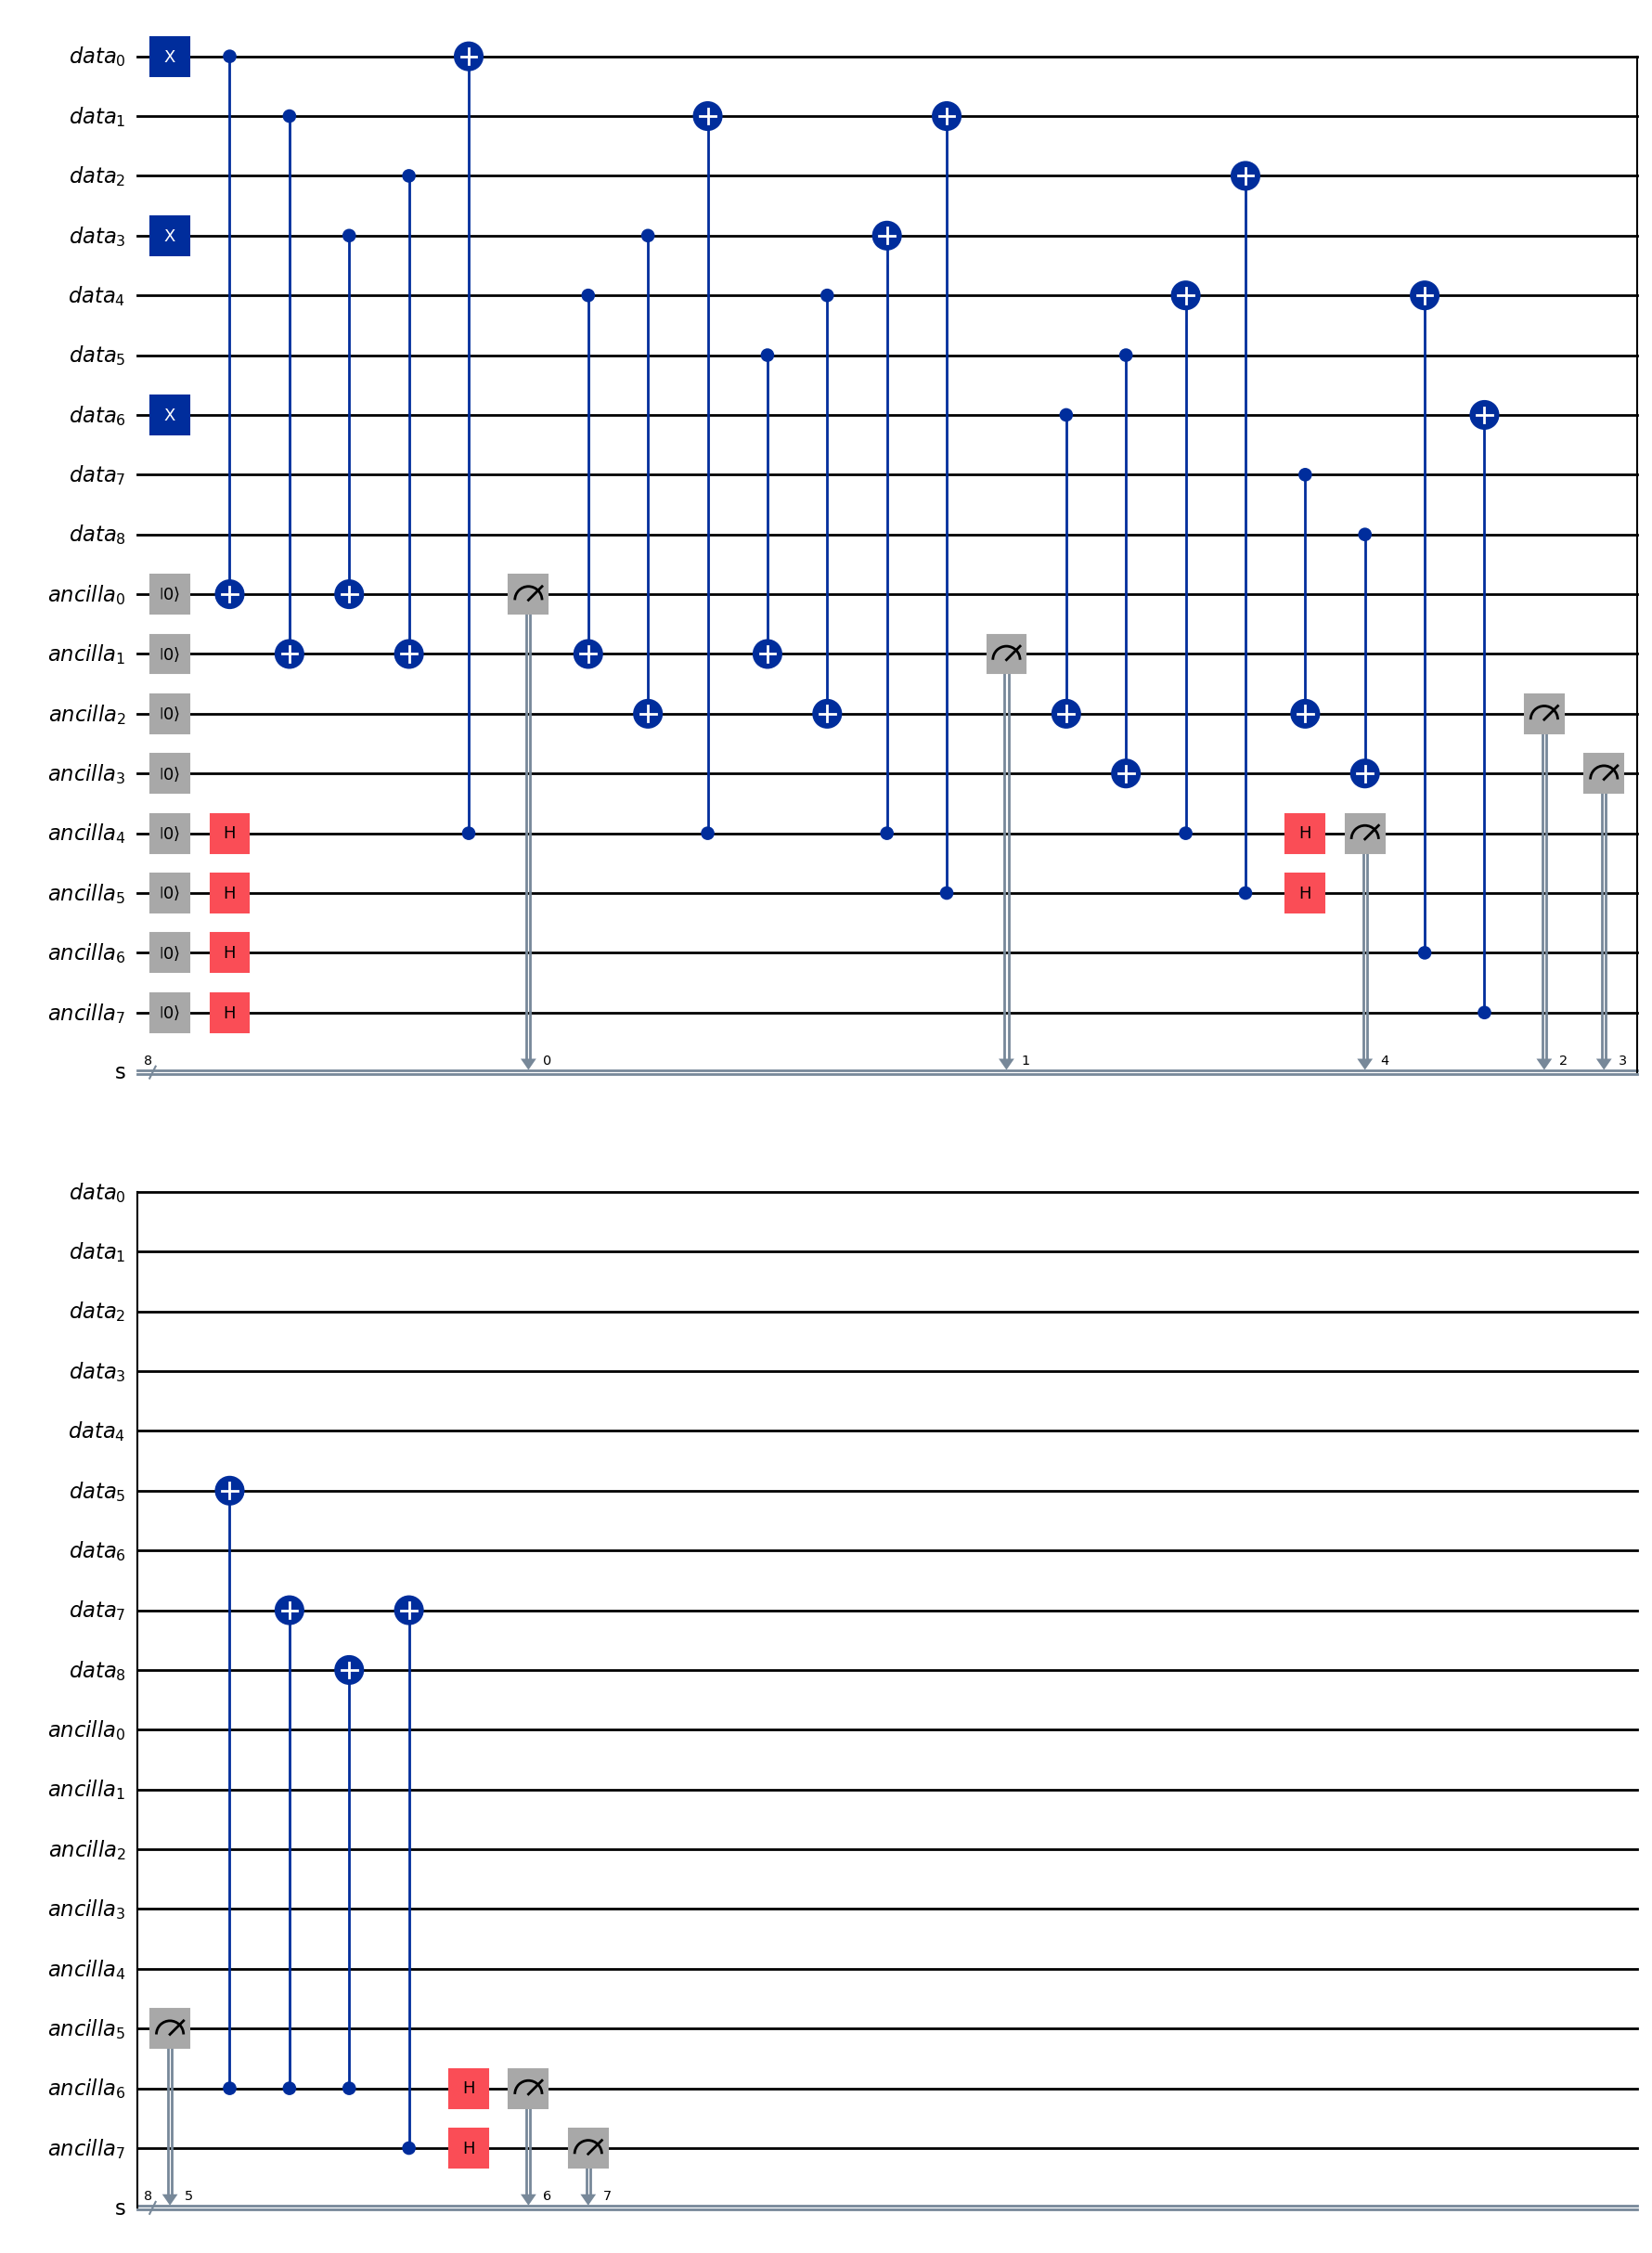

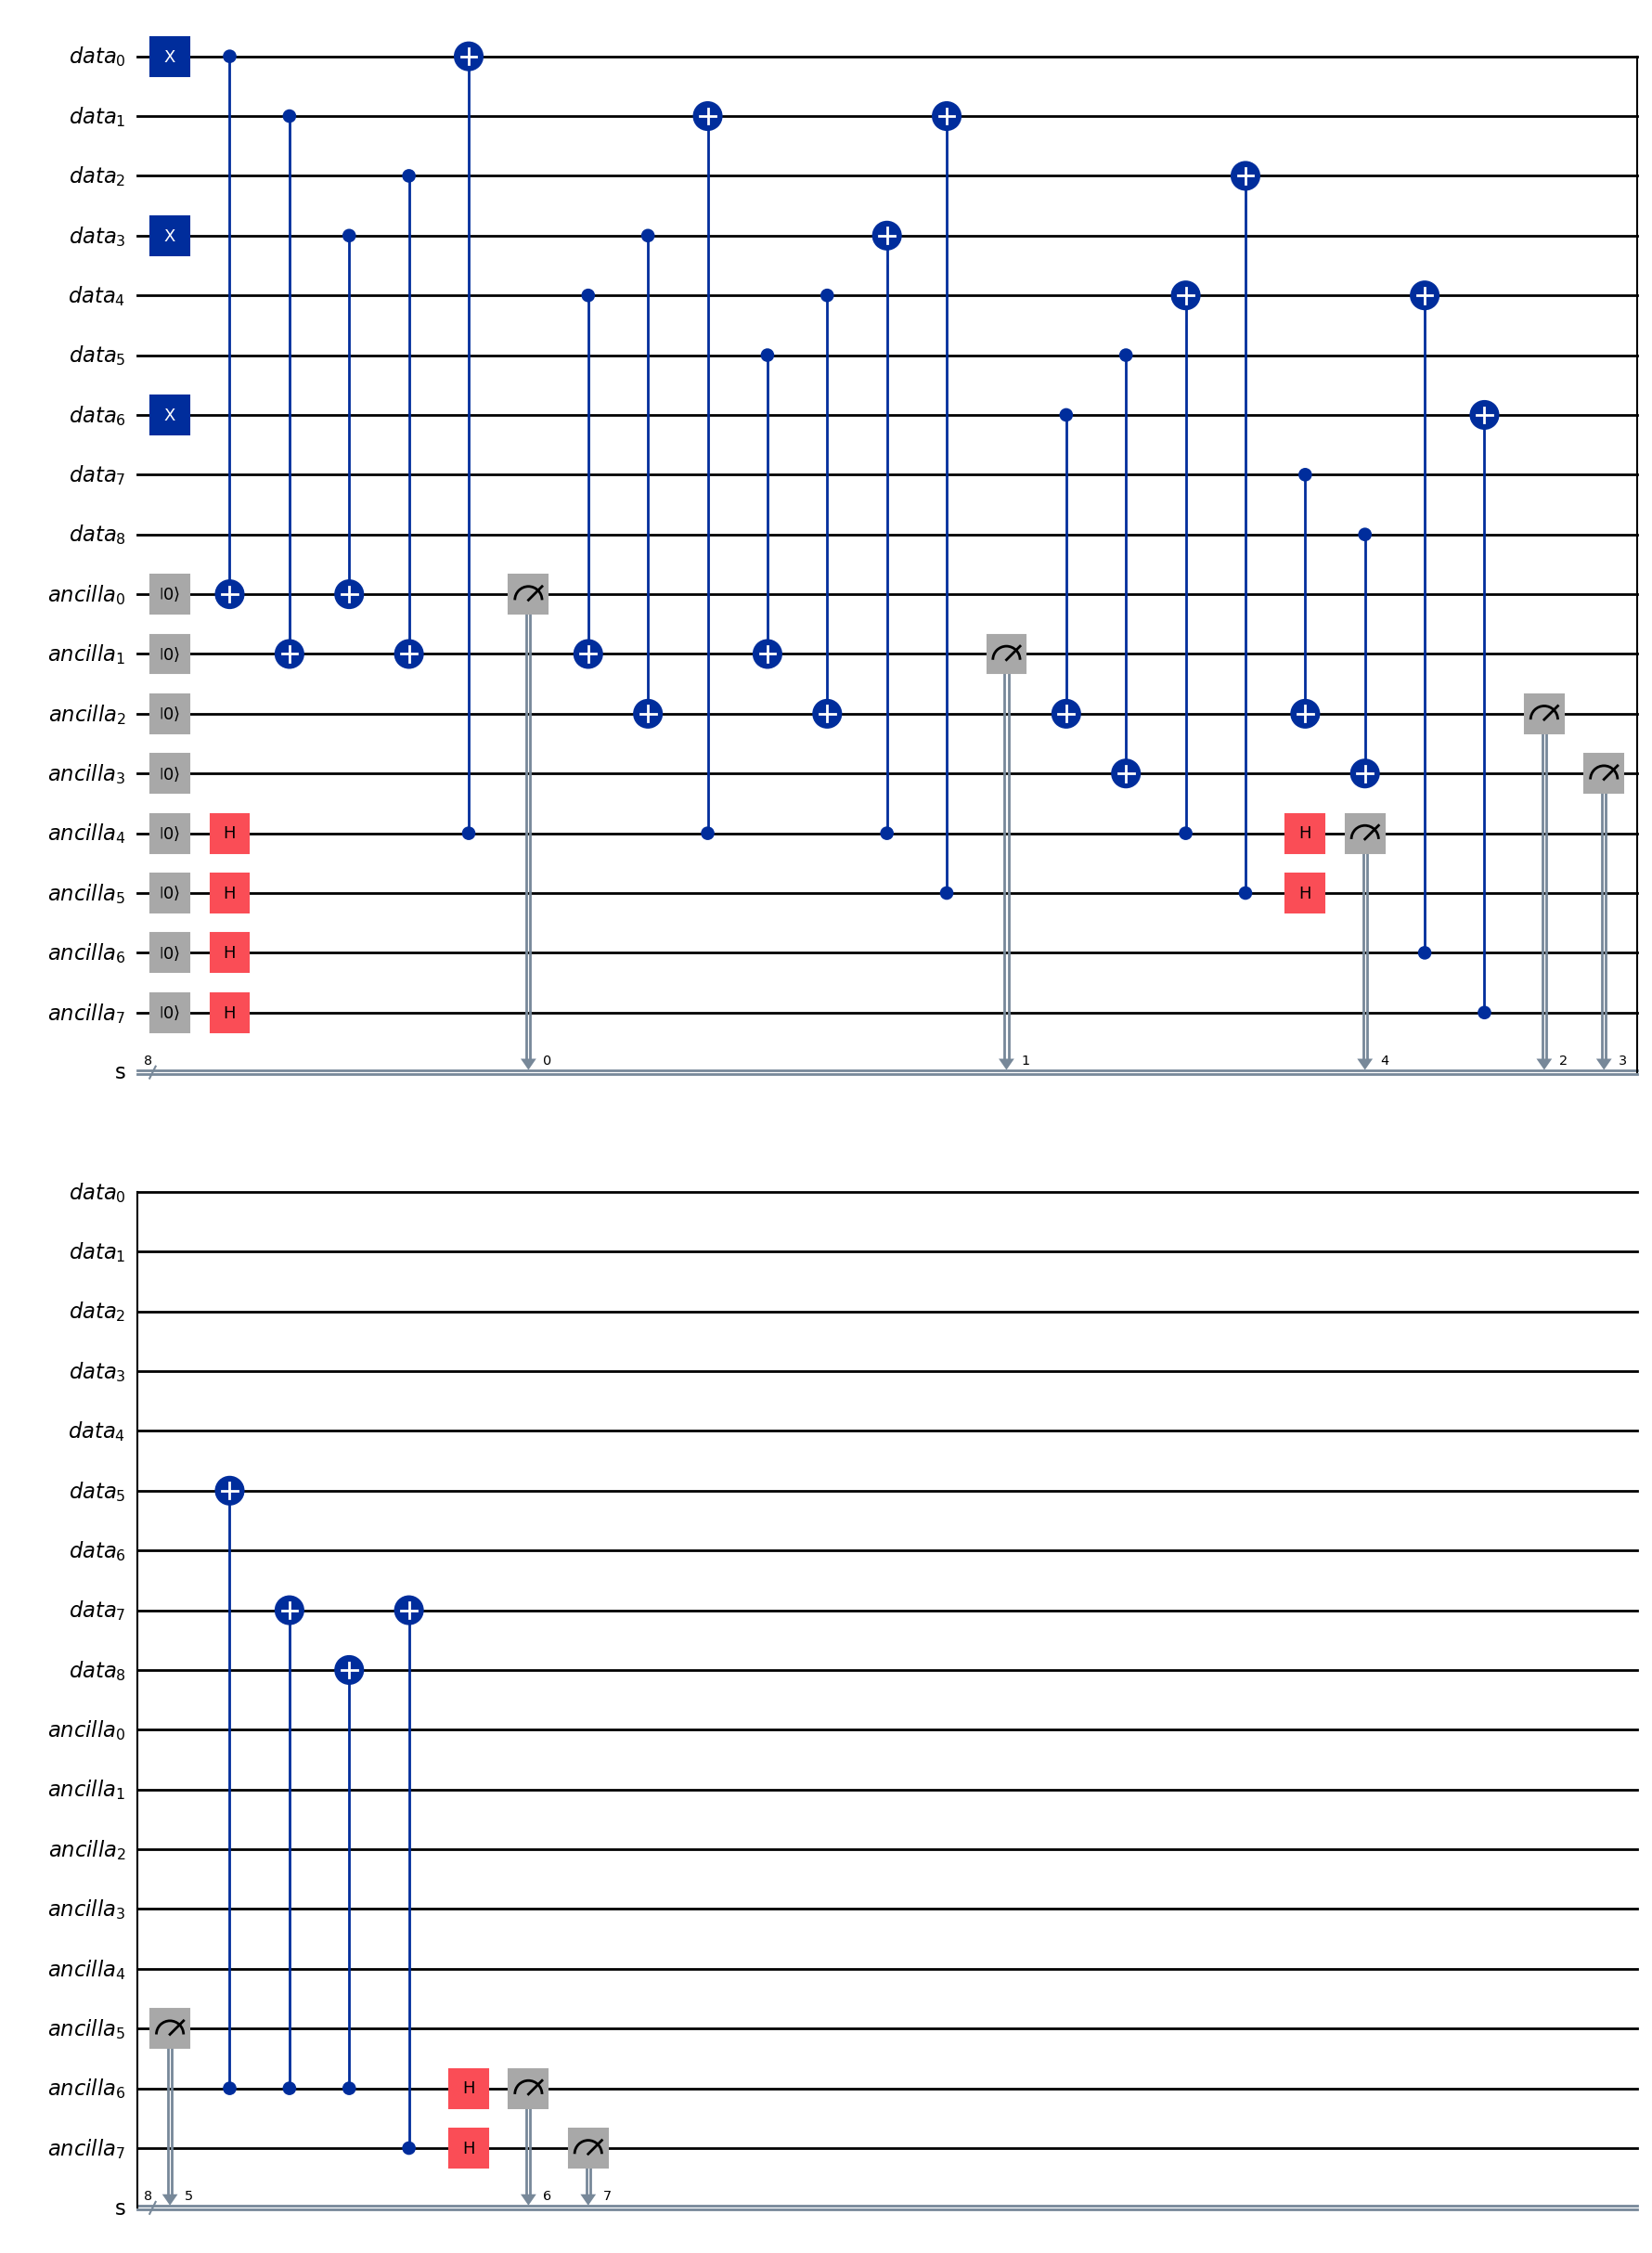

In [24]:
# --- TEST 1 - no error ---
counts, qc = run_surface_code(
    logical_state="0",
    shots=1024
)

# Display results
def display(counts):
    print("Syndrome Measurement Results:")
    for outcome, freq in sorted(counts.items()):
        percent = 100 * freq / sum(counts.values())
        print(f"{outcome} → {freq} shots ({percent:.2f}%)")

display(counts)

# Comment it out if you don't want to see the circuit!
qc.draw('mpl')


#### Interpreting Syndrome Results (No Errors Injected)

Let’s now analyze the syndrome results from a full QEC cycle **with no errors injected**. These 8-bit strings represent the outcomes of the 8 stabilizer measurements.

**Bit-Order - Little Endian Convention**

As mentioned earlier, Qiskit stores classical measurement results in **little-endian** order (right-to-left). That means, in our left-to-right order:

- **Bit 0** corresponds to the syndrome of **X-stabilizer 4**
- **Bit 7** corresponds to the syndrome of **Z-stabilizer 0**
  
...
  
The bits are listed **right-to-left** in the printed string. So:

- `'00000000'` → all stabilizers returned `+1`
- `'11110000'` → all Z-stabilizers returned `+1`, and all X-stabilizers returned `-1`

---

#### What Do These Results Mean?

When no error is injected, the encoded logical state lies in the **+1 eigenspace of all stabilizers**, so ideally, we should only observe the syndrome `'00000000'`.

However, in simulation, you observe a spread over 16 different outcomes, all of the form:

`xxxx0000`


That is: **the last 4 bits are always 0**, and only the **first 4 bits (X-stabilizers)** vary.

---

#### Why This Happens

This is due to quantum superposition and entanglement, since our logical qubit $|\bar 0 \rangle_L$ is only stabilized along Z.

Consider a single qubit $|0\rangle$. When you project it along the X-basis, you get an equal superposition: each ancilla is in the state $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$. Then, we measure in the Z-basis, resulting in a random outcome. That is simply because $|0\rangle$ is stabilized along Z, not X. Suppose we took our logical state to be $|+ \bar \rangle_L$, the GHZ state. This state is stabilized along X, and we would observe the random distribution along Z this time when we project $|\bar +\rangle_L$ along Z and measure it in the X-basis.

>Exercise: Recall - What would a true logical $|0\rangle_L$ state need to satisfy? *(Hint: Revisit the section on Logical State Preparation)*

---

#### Final Insight

Despite observing a distribution over 16 different syndrome strings, the key observation is:

- **Bits 4–7 = 0000** in all outcomes → **no $Z$ errors occurred**
- The variation in bits 0–3 reflects expected sampling over the Z-stabilizer space, not an actual bit-flip error

This matches our expectation for a noiseless run with ideal ancilla measurements: **the code detects no errors**, and the only variability arises from projection in the syndrome basis.

---

Let's now inject an X-error and see what happens.

In [28]:
# --- TEST 2 - X error ---
counts, qc = run_surface_code(
    logical_state="0",
    add_error=True,
    error_type="X",           
    error_location=4,         # Qubit index from 0 to 8: only the output is little-endian!
    shots=1024
)

display(counts)

Syndrome Measurement Results:
00000110 → 56 shots (5.47%)
00010110 → 73 shots (7.13%)
00100110 → 58 shots (5.66%)
00110110 → 57 shots (5.57%)
01000110 → 53 shots (5.18%)
01010110 → 66 shots (6.45%)
01100110 → 64 shots (6.25%)
01110110 → 77 shots (7.52%)
10000110 → 66 shots (6.45%)
10010110 → 61 shots (5.96%)
10100110 → 66 shots (6.45%)
10110110 → 56 shots (5.47%)
11000110 → 72 shots (7.03%)
11010110 → 68 shots (6.64%)
11100110 → 55 shots (5.37%)
11110110 → 76 shots (7.42%)


#### Interpreting Syndrome Results (X Error on Qubit 4)

We injected a single Pauli-$X$ error on **data qubit 4**, then ran one full cycle of stabilizer measurements. The resulting syndrome strings were:

`xxxx0110`


Once again, recall that each syndrome string represents the eigenvalues (±1) of the 8 stabilizers, mapped to bits using **Qiskit's little-endian convention**. This means:

| Bit Index | Syndrome Bit | Stabilizer       | Type |
|-----------|---------------|------------------|------|
| 7         | Z₁            | $Z_0 Z_3$         | Z    |
| 6         | Z₂            | $Z_1 Z_2 Z_4 Z_5$ | Z    |
| 5         | Z₃            | $Z_3 Z_4 Z_6 Z_7$ | Z    |
| 4         | Z₄            | $Z_5 Z_8$         | Z    |
| 3         | X₁            | $X_0 X_1 X_3 X_4$ | X    |
| 2         | X₂            | $X_1 X_2$         | X    |
| 1         | X₃            | $X_4 X_5 X_7 X_8$ | X    |
| 0         | X₄            | $X_6 X_7$         | X    |

In the table, each bit is interpreted **left-to-right**, meaning bit 0 is the leftmost digit in the syndrome string.

---

### What the Syndrome Tells Us

- The injected $X$ error anticommutes with the **Z-stabilizers** that involve qubit 4.
- Qubit 4 appears in:
  - $Z_1 Z_2 Z_4 Z_5$ ($Z_2$ → bit 1)
  - $Z_3 Z_4 Z_6 Z_7$ ($Z_3$ → bit 2)

These two stabilizers should return $-1$ if the $X$ error on qubit 4 is correctly detected.

Indeed, every syndrome in the dataset has:

- **Bit 1 = 1** → $Z_1 Z_2 Z_4 Z_5$ detected an error
- **Bit 2 = 1** → $Z_3 Z_4 Z_6 Z_7$ detected an error
- **Bits 4–7 = xxxx** → all X-stabilizers report no $Z$ error (as expected)

--- 

Something interesting happens when we inject a Z-error. Let's see why.

In [31]:
# --- TEST 3 - Z error ---
counts, qc = run_surface_code(
    logical_state="1",
    add_error=True,
    error_type="Z",           
    error_location=0,         # Qubit index from 0 to 8: only the output is little-endian!
    shots=1024
)

display(counts)

Syndrome Measurement Results:
00000000 → 70 shots (6.84%)
00010000 → 71 shots (6.93%)
00100000 → 71 shots (6.93%)
00110000 → 63 shots (6.15%)
01000000 → 60 shots (5.86%)
01010000 → 62 shots (6.05%)
01100000 → 72 shots (7.03%)
01110000 → 78 shots (7.62%)
10000000 → 42 shots (4.10%)
10010000 → 61 shots (5.96%)
10100000 → 56 shots (5.47%)
10110000 → 71 shots (6.93%)
11000000 → 63 shots (6.15%)
11010000 → 57 shots (5.57%)
11100000 → 75 shots (7.32%)
11110000 → 52 shots (5.08%)


But wait—looking at the syndrome results after injecting a $Z$ error, we notice something strange:

> The syndrome is **exactly the same** as in the no-error case.

**So what's wrong?**  
Actually, nothing! This is precisely what we should expect.

---

Recall: our prepared logical state is $\lvert 0\rangle_L$, which is a **+1 eigenstate of all $Z$-stabilizers** by construction. But more importantly:

- Each individual data qubit is initialized to $\lvert 0\rangle$
- The state $\lvert 0\rangle$ is an eigenstate of the Pauli-$Z$ operator with eigenvalue $+1$
- Therefore, applying a $Z$ error (i.e., a phase flip) **does not change** the measurement outcome of any $Z$ operator—it **commutes** with both the stabilizers and the logical state

---

#### What About the X-Stabilizers?

To detect $Z$ errors, we rely on the **X-type stabilizers**, since $Z$ anticommutes with $X$.

These are measured by:
- Initializing an ancilla in the $X$ basis ($\lvert + \rangle = \frac{1}{\sqrt{2}}(\lvert 0\rangle + \lvert 1\rangle)$)
- Entangling it with data qubits via CNOT
- Collapsing the ancilla back to the $Z$-basis
- Measuring in the $Z$ basis

This works **only if the data qubits themselves are in superposition states**. But in our current setup, the logical $\lvert \bar 0 \rangle_L$ is not a superposition of $\lvert 0\rangle$ and $\lvert 1\rangle$—it is *stabilized by $Z$*, not $X$.

So: **$Z$ errors go undetected** because the state lacks coherence in the $X$ basis for the error to reveal itself.

---

#### How to Test Z-Errors Then?

To test $Z$ error detection, we need to prepare a state that is sensitive to $Z$ flips. An easy version of this would be to:

- Prepare the logical $\lvert \bar + \rangle_L$ state, which is stabilized by all $X$-type stabilizers
- Inject a $Z$ error
- The $Z$ will then **anticommute** with some $X$-stabilizers, producing a nontrivial syndrome

>Exercise: This is a valuable exercise, and as such, I will leave it to you to test it out. *(Hint: All you need to do is prepare the GHZ state $|\bar + \rangle = |+ \dots + \rangle$*

#### For the More Advanced Reader
>Exercise: You may wish to prepare a logical $|+\rangle_L$ that is a +1 eigenstate of all $Z$-type and $X$-type stabilizers. 

### 3.2 Decoding

Once we've measured the stabilizers and extracted a syndrome, the next step in a quantum error correction (QEC) cycle is **decoding**: determining what (if any) error occurred and how to correct it.

---

#### What Does the Decoder Do?

The syndrome provides a **pattern of stabilizer flips** (±1 eigenvalues), which reflects where errors may have occurred. The decoder's job is to:

1. **Interpret the syndrome** to infer the most likely set of errors
2. **Apply a recovery operation** that ideally restores the logical state to its original form


---

#### Minimum-Weight Perfect Matching (MWPM)

In the surface code, the dominant class of decoders is based on **minimum-weight perfect matching** (MWPM). Here's the high-level idea:

- Each stabilizer flip is viewed as a **defect** (a vertex)
- The decoder attempts to find **pairs of defects** and connect them with the **shortest possible error chains** (edges)
- These pairings are used to infer the most probable set of physical errors

This turns the decoding task into a **graph-theoretic optimization problem**: find a set of edges that connect the defects with minimal total “weight” (i.e., fewest or lowest-cost errors).

Libraries like **PyMatching**, **Stim**, and **Fusion Blossom** implement MWPM efficiently for large-scale simulations.

---

#### A Simpler Approach: Lookup Tables

For the purpose of this tutorial, we'll take a simpler path.

Because we're working with a **small code (distance-3)** and well-controlled error injection, we can use a **lookup table decoder**:

- For each possible single-qubit error, we precompute its syndrome
- When we measure a syndrome, we simply **look it up** and apply the corresponding recovery operation

This method is:

- Simple to implement
- Deterministic and explainable
- Sufficient for testing and education

It doesn't scale, but it gives us full visibility into how the code responds to each type of error.

---

Let's build this lookup table now for our X-error.


In [37]:
# Build a lookup table: Z-syndrome → list of qubits with equivalent X error signatures
lookup_table = {}

for qubit in range(9):
    # Run the surface code with a single X error
    counts, _ = run_surface_code(
        logical_state="0",
        add_error=True,
        error_type="X",
        error_location=qubit,
        shots=1
    )

    # Extract syndrome string and keep only the Z-stabilizer part (bits 0–3)
    full_syndrome = list(counts.keys())[0]
    z_syndrome = full_syndrome[-4:]

    # Add qubit to list for this syndrome
    if z_syndrome not in lookup_table:
        lookup_table[z_syndrome] = []
    lookup_table[z_syndrome].append(qubit)

# Print the lookup table
print("Z-stabilizer Syndrome → X Error Candidates")
for syndrome, qubit_list in sorted(lookup_table.items()):
    qlist = ', '.join(str(q) for q in qubit_list)
    print(f"{syndrome} → qubits {qlist}")


Z-stabilizer Syndrome → X Error Candidates
0001 → qubits 0
0010 → qubits 1, 2
0100 → qubits 6, 7
0101 → qubits 3
0110 → qubits 4
1000 → qubits 8
1010 → qubits 5


#### Interpreting the X-Error Lookup Table and Degeneracy

Notice that multiple qubits map to the **same syndrome**:

- Syndrome `0010` corresponds to errors on **qubit 1 or 2**
- Syndrome `0100` corresponds to **qubit 6 or 7**

This is a feature—not a flaw—of stabilizer codes: **different physical errors can produce the same syndrome**. This is called **degeneracy**.

In such cases, the syndrome does not uniquely determine the exact error that occurred—it only indicates that the error lies in an **equivalence class** that produces the same logical effect.

---

### How MWPM Handles Degeneracy

Minimum-Weight Perfect Matching (MWPM) decoders interpret the syndrome as a set of **defects** (violated stabilizers), then:

1. **Constructs a graph** where nodes = defects and edges = possible error paths
2. Assigns weights to edges based on likelihood (e.g., length, noise model)
3. **Finds the pairing of defects with minimum total weight**

The result is a **set of recovery operations** that restores the state, up to a logical equivalence.

Importantly:
- MWPM does **not try to guess the exact error**
- It finds a **correction path** that returns the system to the codespace without changing the logical state

---

### Lookup Table vs. MWPM

In our tutorial, we use a simple **lookup table** to map syndromes to likely errors. This is sufficient for:

- Educational purposes
- Controlled, single-error scenarios
- Codes of small distance

For larger codes or realistic noise models, MWPM (or neural/heuristic decoders) become essential.

>Exercise: Add a function to our surface-17 code implementation that reverses the error (i.e. if an X-error occured on qubit 5, apply an X-gate on qubit 5 to reverse it).

## Section 4 - Running on Real Quantum Hardware

Executing quantum error correction on real hardware is where theory meets practice. In this section, we’ll run a simplified version of our Surface-17 code on an IBM Quantum device and examine the measured syndromes.

---

### Adapting for Hardware Constraints

Running on actual superconducting hardware introduces several important constraints:

1. **Circuit Depth**  
   A full Surface-17 cycle includes 8 stabilizer measurements and dozens of two-qubit gates. This may exceed the coherence time of many current devices.  
   → **Solution:** We limit ourselves to a small, representative subset (e.g., 2 Z-stabilizers and 2 X-stabilizers).

2. **Qubit Connectivity**  
   Surface codes assume a 2D nearest-neighbor lattice, but hardware layouts vary.  
   → **Solution:** We allow Qiskit’s transpiler to map our logical layout to the hardware topology.

3. **Noise and Imperfections**  
   Real qubits suffer from gate errors, readout noise, and decoherence. This noise is not just a nuisance—it’s a chance to demonstrate how error correction identifies and mitigates physical errors.

---

### Execution Strategy

For this tutorial, we will be implementing a simple 2-qubit stabilizer circuit on real quantum hardware to demonstrate how error detection works and to showcase execution on actual IBM devices.

To keep the circuit depth and hardware load within practical limits, we execute the following steps:

1. Prepare a known input state (e.g., \$\lvert 00\rangle\$ or a Bell-like superposition)
2. Optionally inject a single \$X\$ error on one data qubit
3. Measure a single \$Z \otimes Z\$ stabilizer using an ancilla qubit
4. Submit the circuit to IBM Quantum hardware using Qiskit Runtime
5. Retrieve the ancilla measurement result to detect any parity flip

This minimal setup captures the essence of stabilizer-based QEC while being fast and reliable enough to run on near-term hardware.

---

### Interpreting Hardware Results

Keep the following in mind when analyzing your results:

- Natural device noise may flip syndrome bits even **without** injected errors
- The difference between "error-injected" and "no-error" cases may be subtle compared to ideal simulation
- This highlights both the challenge and the necessity of error correction in real quantum systems

---

### Runtime Considerations

We estimate hardware execution time (excluding queue time) based on:

- Circuit depth (after transpilation)
- Number of shots
- Device configuration (e.g., gate times)

To meet the challenge requirement, our job’s runtime should stay **under 5 minutes**. If our circuit runs longer, we should consider reducing the number of shots or stabilizers measured.

---

### Running the Code on IBM Quantum

To run the surface code circuit on real IBM hardware, you’ll need:

1. An IBM Quantum account and an active API token
2. A configured Qiskit runtime environment (`IBMQ.save_account(...)`)
3. An available backend device
4. The hardware submission code (see next cell)

> **Tip:** Save your job ID so you can retrieve results later using `backend.retrieve_job(job_id)`

> **Note:** Queue times can range from minutes to hours depending on the device and your account tier.


First, add your IBM token API, which can be found by going to your IBM Quantum account.


In [59]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Replace YOUR_API_TOKEN with the token you copy from your IBM Quantum account
QiskitRuntimeService.save_account("YOUR_API_TOKEN", channel = 'ibm_quantum', overwrite=True)

Next, we check operational backends to select which one we'd like to use.

In [61]:
service = QiskitRuntimeService()

for backend in service.backends(simulator=False, operational=True):
    print(f"{backend.name} – {backend.configuration().num_qubits} qubits")

/var/folders/lb/k9c749qx1ll6mp64ytjf9lg00000gn/T/ipykernel_54507/1010201640.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


ibm_brisbane – 127 qubits
ibm_sherbrooke – 127 qubits


Next, we implement our 2-qubit stabilizer circuit, and define a local run function to test it.

2-Qubit ZZ Stabilizer Circuit:
        ┌───┐             
data_0: ┤ X ├──■──────────
        └───┘  │          
data_1: ───────┼────■─────
             ┌─┴─┐┌─┴─┐┌─┐
   anc: ─────┤ X ├┤ X ├┤M├
             └───┘└───┘└╥┘
   c: 1/════════════════╩═
                        0 

Simulation Results:
1: 1024 shots (100.00%)


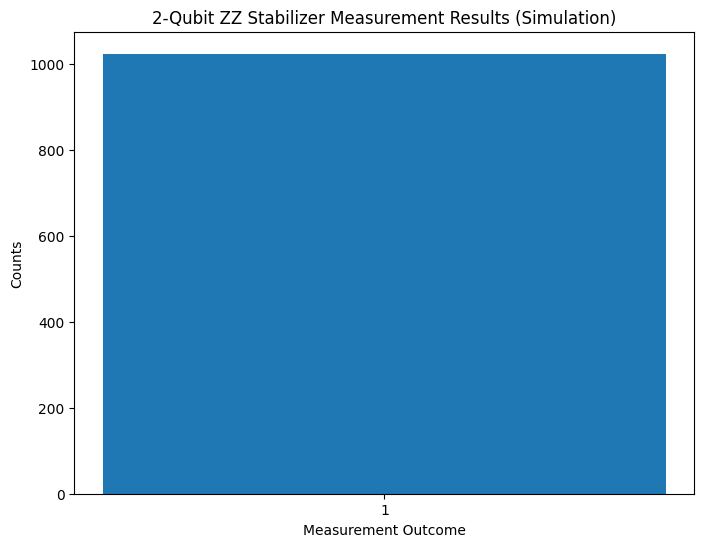

In [77]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
import matplotlib.pyplot as plt
import numpy as np

def create_2qubit_stabilizer_circuit():
    """
    Creates a simple 2-qubit circuit that measures the ZZ stabilizer.
    This is the simplest possible stabilizer measurement circuit.
    
    Returns:
    - qc: The quantum circuit
    """
    # Create registers
    data = QuantumRegister(2, 'data')  # 2 data qubits
    anc = QuantumRegister(1, 'anc')    # 1 ancilla qubit
    cr = ClassicalRegister(1, 'c')     # 1 classical bit for measurement
    qc = QuantumCircuit(data, anc, cr)
    
    # Optional: Prepare a specific state
    # For |00⟩ state, do nothing (default state)
    # For |11⟩ state, apply X to both qubits
    # qc.x(data[0])
    # qc.x(data[1])
    
    # Measure ZZ stabilizer
    qc.x(data[0])          # Simulate X-error
    qc.cx(data[0], anc[0]) # CNOT from ancilla to first data qubit
    qc.cx(data[1], anc[0]) # CNOT from ancilla to second data qubit
    qc.measure(anc[0], cr[0]) # Measure the ancilla
    
    return qc

def run_locally():
    """
    Runs the 2-qubit stabilizer circuit locally on the simulator.
    """
    from qiskit_aer import AerSimulator
    
    # Create the circuit
    qc = create_2qubit_stabilizer_circuit()
    
    # Display the circuit
    print("2-Qubit ZZ Stabilizer Circuit:")
    print(qc.draw(output='text'))
    
    # Run on simulator
    backend = AerSimulator()
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t, shots=1024).result()
    counts = result.get_counts()
    
    # Display results
    print("\nSimulation Results:")
    for outcome, count in counts.items():
        print(f"{outcome}: {count} shots ({100*count/1024:.2f}%)")
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title("2-Qubit ZZ Stabilizer Measurement Results (Simulation)")
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Counts")
    plt.show()
    
    return qc

# Run locally first to test
qc = run_locally()

After that, we define our `run_on_ibm` and `retrieve_ibm_results` functions.

In [106]:
def run_on_ibm():
    """
    Runs the 2-qubit stabilizer circuit on IBM Quantum hardware.
    
    Returns:
    - job_id: The job ID for retrieving results later
    - qc: The quantum circuit that was submitted
    """
    # Create the circuit
    qc = create_2qubit_stabilizer_circuit()
    
    # Connect to IBM Quantum
    service = QiskitRuntimeService()
    
    # Select a backend (choose a device with good connectivity)
    backend = service.backend('ibm_brisbane')
    print(f"Running on {backend.name}")
    
    # Estimate runtime
    circuit_depth = qc.depth()
    shots = 1024
    estimated_runtime = (circuit_depth * shots) / 1000  # Very rough estimate in seconds
    print(f"Estimated runtime: {estimated_runtime:.2f} seconds (excluding queue time)")
    
    # Submit the job
    qc_t = transpile(qc, backend, optimization_level=1, translation_method="translator")
    sampler = Sampler(mode=backend)
    job = sampler.run([qc_t])

    job_id = job.job_id()
    print(f"Job submitted with ID: {job_id}")
    print("You can save this ID to retrieve results later.")
    
    return job_id, qc

def retrieve_ibm_results(job_id, shots=1024):
    """
    Retrieves and analyzes results from a previously submitted IBM Quantum job.

    Parameters:
    - job_id: The job ID returned from run_on_ibm
    - shots: Number of shots originally submitted

    Returns:
    - traditional_counts: Dictionary of bitstring counts
    """
    from qiskit_ibm_runtime import QiskitRuntimeService
    import matplotlib.pyplot as plt

    # Load job
    service = QiskitRuntimeService()
    job = service.job(job_id)
    
    # Check status
    status = job.status()
    print(f"Job status: {status}")
    if status != "DONE":
        print("Job not complete yet.")
        return None

    # Get results
    result = job.result()[0]
    counts = result.join_data().get_counts()

    # Display results
    print("\nIBM Quantum Results:")
    total = sum(counts.values())
    for b, c in sorted(counts.items()):
        print(f"{b}: {c} shots ({100*c/total:.2f}%)")

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(counts.keys(), counts.values())
    plt.title("IBM Hardware Results: ZZ Stabilizer")
    plt.xlabel("Syndrome Outcome")
    plt.ylabel("Counts")
    plt.show()

    return counts

Now, all we have to do is run it!

In [78]:
job_id, qc_ibm = run_on_ibm()

/var/folders/lb/k9c749qx1ll6mp64ytjf9lg00000gn/T/ipykernel_54507/548037452.py:13: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Running on ibm_brisbane
Estimated runtime: 4.10 seconds (excluding queue time)
Job submitted with ID: d0mqkex5nwm00085k8j0
You can save this ID to retrieve results later.


/var/folders/lb/k9c749qx1ll6mp64ytjf9lg00000gn/T/ipykernel_54507/1055101482.py:51: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Job status: DONE

IBM Quantum Results:
0: 137 shots (3.34%)
1: 3959 shots (96.66%)


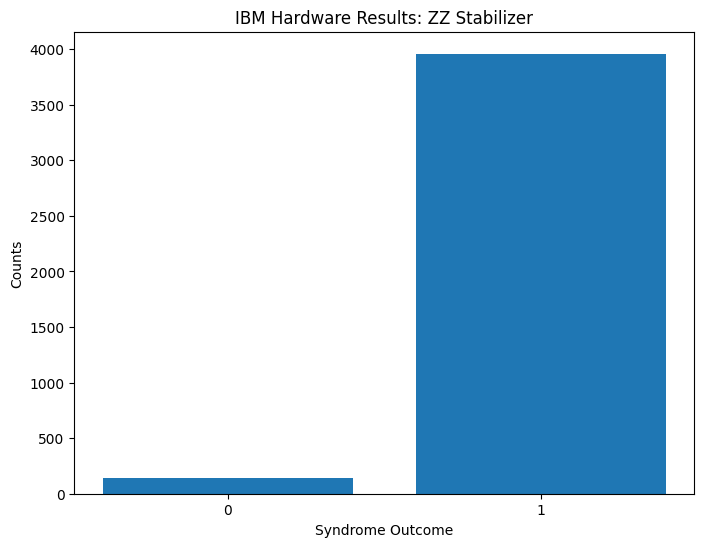

In [107]:
# To retrieve results:
results = retrieve_ibm_results("d0mqkex5nwm00085k8j0")

This is what we expect (allowing for hardware error which results in somme syndrome measurements being 0).

>Exercise: experiment with the circuit. Try applying an X-error on both qubits; first hypothesize what you expect to happen, and then run it locally and on IBM's hardware. 

## Extension: Heavy-Hex Lattices Instead of Planar Lattices

IBM's current superconducting quantum hardware is built on a non-square geometry known as the **heavy-hex lattice**. This layout limits each qubit to a maximum of three connections, which reduces crosstalk and improves gate fidelity compared to full square lattices (refer to Paper 3 under "References"). However, this also imposes nontrivial constraints on quantum error correction (QEC), especially for codes originally designed for regular 2D grids, like surface codes. 

Standard planar surface codes assume a square lattice with four-neighbor connectivity to support stabilizers like $XXXX$ or $ZZZZ$ acting locally on plaquettes, as we've seen in this tutorial. On the heavy-hex lattice, these stabilizers must be implemented through non-local CNOT sequences or elongated ancilla chains, increasing circuit depth and error exposure. While planar and rotated surface codes can still be implemented, doing so requires significant adjustments to layout, scheduling, and decoding strategies. Performance is highly sensitive to these implementation details.

In contrast, certain QEC families are inherently more compatible with the constraints of heavy-hex hardware. **Bacon-Shor codes** are particularly effective due to their use of low-weight, gauge-based stabilizers. These codes measure simple two-qubit checks along rows and columns, making them naturally suited to architectures with limited connectivity. Their syndrome extraction circuits are shallower, and they perform well under realistic noise models including two-qubit gate and measurement errors.

**Subsystem surface codes** (a generalization of stabilizer codes) also show promise on heavy-hex devices. By encoding some stabilizers as gauge qubits (these are not part of the stabilizer group but commute with the logical operators and can be measured without disturbing the encoded logical information), they reduce the need for high-weight checks. This makes them favorable in regimes where two-qubit gate errors dominate, as is often the case in superconducting architectures. These codes provide a trade-off: they can achieve better compatibility and lower overhead, though possibly at the expense of some error-correcting power.

**Rotated surface codes** (like our surface-17 code), while structurally closer to the standard surface code, offer a middle ground. Their more compact layout reduces the number of physical qubits and stabilizers required, which can help fit them into the heavy-hex topology more efficiently. With careful placement and decoder optimization, they *can* reach competitive logical error rates.

### TL;DR (Too Long; Didn't Read)
IBM’s heavy-hex lattice architecture prioritizes gate fidelity and noise suppression by limiting qubit connectivity. This necessitates careful adaptation of traditional surface codes. While these can still be used effectively, alternative codes like Bacon-Shor and subsystem surface codes offer practical advantages in this layout by using lower-weight checks and shallower circuits—leading to improved performance under realistic noise models.

## Conclusion: The Road to Fault-Tolerant Quantum Computing

In this tutorial, we've explored the Surface-17 code, a practical implementation of quantum error correction that represents a stepping stone toward fault-tolerant quantum computing. Let's reflect on what we've learned and consider the broader implications.

### What We've Accomplished

We began our journey with classical repetition codes, understanding how redundancy can protect information against noise. We then navigated the unique challenges of quantum information—the no-cloning theorem, the dual nature of quantum errors, and the need for indirect measurement techniques.

Through our implementation of the Surface-17 code, we've seen how:

1. **Stabilizer measurements** allow us to detect errors without collapsing the quantum state
2. **Syndrome extraction** provides a classical fingerprint of quantum errors
3. **Error detection** works differently for bit-flip (X) and phase-flip (Z) errors
4. **Real quantum hardware** introduces its own noise, demonstrating why QEC is necessary

Our experiments, both in simulation and on real quantum hardware, have shown the promise and challenges of quantum error correction. The difference between ideal results and hardware results highlights the current state of quantum computing: we're at the threshold where QEC concepts can be demonstrated.

### The Bigger Picture

Quantum error correction is not just a technical necessity—it's the bridge between today's noisy intermediate-scale quantum (NISQ) devices and the fault-tolerant quantum computers of tomorrow. The Surface-17 code we've explored is a microcosm of the larger surface code family that may one day protect quantum information across millions of physical qubits.

The concepts we've covered—stabilizers, syndrome extraction, and error detection—form the foundation of all quantum error correction schemes. By understanding these principles at the level of a small code like Surface-17, you're equipped to explore more advanced topics like:

- Fault-tolerant logical operations
- Code concatenation and resource optimization
- Topological quantum computing
- Measurement-based quantum computation

### Looking Forward

As quantum hardware continues to improve, the error rates will decrease and coherence times will increase. Eventually, we'll cross the threshold where quantum error correction provides a net benefit, enabling computations that would be impossible with unprotected qubits.

The journey from today's demonstrations to tomorrow's fault-tolerant quantum computers will require advances in:

1. **Hardware**: Lower error rates, better connectivity, and more qubits
2. **Software**: More efficient decoders and syndrome extraction circuits
3. **Theory**: New codes with better thresholds and resource requirements

By understanding quantum error correction from first principles, as we've done in this tutorial, you're prepared to contribute to this exciting frontier of quantum computing research and development.

Whether you're a student, researcher, or quantum engineer, I hope this tutorial has demystified quantum error correction and inspired you to explore further. The path to fault-tolerant quantum computing is challenging, but with each implementation and experiment, we move one step closer to unlocking the full potential of quantum information processing.


## For Further Reading

For a deeper understanding of the theory and practical implementation of quantum error correction and surface codes, I recommend the following references:

1. **Y. Tomita and K. M. Svore**,
   *Low-Distance Surface Codes under Realistic Quantum Noise*,
   *Physical Review A*, **90**, 062320 (2014).
   [arXiv:1404.3747](https://arxiv.org/abs/1404.3747)
   Explores the performance of low-distance surface codes (including the Surface-17 layout) under circuit-level depolarizing noise, with realistic hardware constraints in mind.

2. **Joschka Roffe**,
   *Quantum Error Correction: An Introductory Guide*,
   [arXiv:1907.11157](https://arxiv.org/abs/1907.11157)
   A pedagogical yet rigorous introduction to the principles of quantum error correction, covering stabilizer codes, logical encoding, syndrome extraction, and an introduction to surface codes.

3. **C. Benito, E. López, B. Peropadre, and A. Bermudez**, *Comparative study of quantum error correction strategies for the heavy-hexagonal lattice*, [Quantum 9, 1623 (2025)](https://quantum-journal.org/papers/q-2025-02-06-1623/pdf) A comprehensive analysis of quantum error correction strategies on IBM's heavy-hexagonal lattice architecture, comparing surface codes, subsystem codes, and Floquet codes under realistic noise models.


